In [1]:
import os, math, h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
from torch import Tensor
from tqdm import tqdm
from models import DriftModel, Interpolant
from utils import TrajectoryDataset, to_grid
from types import SimpleNamespace

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Config
WINDOW = 7  # must be >=2 (this decides cond channels)
CKPT_PATH = f"./checkpoints/latest_3hrly_window_{WINDOW}_cosine_normalized.best.pt"   # your trained weights
# CKPT_PATH = f"./checkpoints/latest_3hrly_window_{WINDOW}_cosine_sigma_1.0_label_noise_0.1_normalized.best.pt"   # your trained weights
TRAIN_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_train.h5"
VAL_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_valid.h5"
USE_VAL = True  # True -> pick from VAL_H5, else TRAIN_H5
INDEX = 0   # which trajectory to demo
BETA_FN = "t^2"  # 't' or 't^2'
SIGMA_COEF = 1.0
EM_STEPS = 200
GUIDE = 0.1 # measurement guidance strength (0 disables)
NORMALIZE = True

# simulate sparse obs (mask target) for demo; replace with your real operator + y_obs if you have one
SIM_SPARSE_OBS = True
OBS_RATIO = 0.25  # 25% pixels observed
OBS_NOISE_STD = 0.0

# SAVE_DIR       = "./nb_outputs"
# Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
def compute_h5_global_mean_std(h5_path: str):
    # Global scalar mean/std across (N,T,C,H,W)
    with h5py.File(h5_path, "r") as f:
        arr = f["x"][:]  # loads to RAM — fine if file is small/moderate; else stream in chunks
    x = torch.from_numpy(arr).float()
    mean = x.mean().item()
    std = x.std().item()
    std = std if std > 0 else 1.0
    return mean, std

if NORMALIZE:
    train_mean, train_std = compute_h5_global_mean_std(TRAIN_H5)
else:
    train_mean, train_std = 0.0, 1.0

print(f"Mean: {train_mean}")
print(f"Std: {train_std}")

Mean: -0.0004427380335982889
Std: 2672.231201171875


In [4]:
# Small helpers
def load_single_trajectory(h5_path: str, idx: int, window: int, normalize=False, mean=0.0, std=1.0) -> Tensor:
    """
    Return (1, T, C, H, W) cropped to window from dataset['x'] (N,T,C,H,W).
    """
    with h5py.File(h5_path, "r") as f:
        x = f["x"][idx]  # (T, C, H, W)
    T = x.shape[0]
    w = min(window, T)
    x = torch.from_numpy(x[:w]).float()  # (w,C,H,W)
    if normalize:
        x = (x - mean) / (std if std > 0 else 1.0)
    return x.unsqueeze(0)  # (1,w,C,H,W)

def build_cond_z0_z1(x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    """
    x: (B, T, C, H, W) with T>=2
    cond = x[:, :-1] flattened over time -> (B, (T-1)*C, H, W)
    z0   = x[:, -2]  (base/last past frame)
    z1   = x[:, -1]  (target frame; optional GT)
    """
    assert x.dim() == 5 and x.shape[1] >= 2
    B, T, C, H, W = x.shape
    past = x[:, :-1]                                 # (B, T-1, C, H, W)
    cond = past.reshape(B, (T-1)*C, H, W).contiguous()
    z0   = x[:, -2]                                  # (B, C, H, W)
    z1   = x[:, -1]                                  # (B, C, H, W)
    return cond, z0, z1

def make_mask_like(z: Tensor, ratio: float, seed: int = 0) -> Tensor:
    g = torch.Generator(device=z.device)
    g.manual_seed(seed)
    return (torch.rand(z.shape, generator=g, device=z.device) < ratio).float()


In [5]:
# Load one trajectory and build conditioning
h5_path = VAL_H5 if USE_VAL else TRAIN_H5
x = load_single_trajectory(h5_path, INDEX, WINDOW,
                           normalize=NORMALIZE, mean=train_mean, std=train_std
                          ).to(device)  # (1,T,C,H,W)
B, T, C, H, W = x.shape
print("shape:", (B, T, C, H, W))

cond, z0, z1 = build_cond_z0_z1(x)  # cond: (1,(T-1)*C,H,W), z0/z1: (1,C,H,W)
cond.shape, z0.shape, z1.shape

shape: (1, 7, 2, 64, 64)


(torch.Size([1, 12, 64, 64]),
 torch.Size([1, 2, 64, 64]),
 torch.Size([1, 2, 64, 64]))

In [16]:
# Load model
# data_cfg: only needs C for channel count
data_cfg = SimpleNamespace(C=C)

# model_cfg: must include all the attributes DriftModel expects
model_cfg = SimpleNamespace(
    unet_channels=64,
    unet_dim_mults=(1, 2, 2),
    unet_resnet_block_groups=8,
    unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64,
    unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True,
    unet_random_fourier_features=False,
    use_classes=False,
)

interp_cfg = SimpleNamespace(
    sigma_coef=1.0,
    beta_fn="t",
    t_min_train=0.0,
    t_max_train=1.0,
    t_min_sampling=0.001,
    t_max_sampling=0.999,
    EM_sample_steps=200
)

cond_channels = cond.shape[1]
drift = DriftModel(
    data_cfg=data_cfg,
    model_cfg=model_cfg,
    cond_channels=cond_channels
).to(device)
drift.eval()

# Load checkpoint: support both {"model": state_dict, ...} and raw state_dict
ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
drift.load_state_dict(state, strict=True)

interp = Interpolant(interp_cfg)

NOT USING CLASSES IN UNET


In [11]:
# Unconditional EM sampler (no guidance)
@torch.no_grad()
def em_sample_uncond(drift, interp, base, cond, steps=300, t_min=0.0, t_max=0.999):
    """
    Euler–Maruyama from base=z0 to t=1, with NO measurement guidance.
    Uses history 'cond' the same way as training (concatenated as channels).
    """
    device = base.device
    ts = torch.linspace(t_min, t_max, steps, device=device)
    dt = float(ts[1] - ts[0])
    xt = base.clone()

    for t in tqdm(ts, desc="EM (uncond)", leave=True):
        tb  = t.repeat(xt.shape[0]).to(device)         # (B,)
        bF  = drift(xt, tb, cond=cond)                 # (B,C,H,W)
        sig = interp.sigma(tb)                         # (B,1,1,1)
        mu  = xt + bF * dt
        xt  = mu + sig * torch.randn_like(mu) * math.sqrt(dt)

    return xt  # (B,C,H,W)


# Unconditional sampling

EM (uncond): 100%|██████████| 200/200 [00:04<00:00, 43.56it/s]


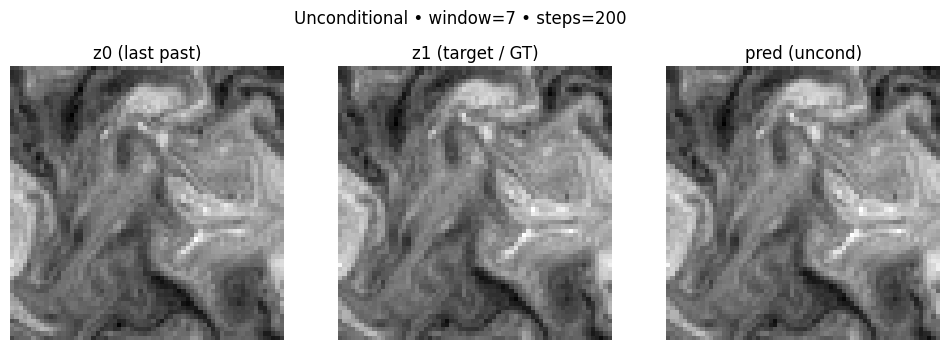

In [12]:
# Run unconditional sampling
pred_uncond = em_sample_uncond(
    drift=drift, interp=interp,
    base=z0, cond=cond,                # history-only conditioning, no observations
    steps=interp_cfg.EM_sample_steps,
    t_min=interp_cfg.t_min_sampling,
    t_max=interp_cfg.t_max_sampling
)

# Visualize
def show_triplet(z0, z1, pred, title=""):
    z0_ = z0[0].detach().cpu()
    z1_ = z1[0].detach().cpu()
    pr_ = pred[0].detach().cpu()

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    def im(ax, img, ttl):
        img = img.squeeze(0) if img.dim()==3 and img.shape[0]==1 else img
        if img.dim()==3 and img.shape[0] in [1,3]:
            ax.imshow(img.permute(1,2,0), cmap=None if img.shape[0]==3 else "gray")
        else:
            ax.imshow(img[0], cmap="gray")
        ax.set_title(ttl); ax.axis("off")

    im(axes[0], z0_, "z0 (last past)")
    im(axes[1], z1_, "z1 (target / GT)")
    im(axes[2], pr_, "pred (uncond)")
    fig.suptitle(title); plt.show()

show_triplet(z0, z1, pred_uncond, title=f"Unconditional • window={T} • steps={EM_STEPS}")


# Conditional sampling

In [17]:
if SIM_SPARSE_OBS:
    mask = make_mask_like(z1, ratio=OBS_RATIO, seed=0).to(device)
    operator = lambda x: x * mask
    y_obs = operator(z1)
    if OBS_NOISE_STD > 0:
        y_obs = y_obs + OBS_NOISE_STD * mask * torch.randn_like(y_obs)
else:
    operator = lambda x: x  # identity (observing full frame)
    y_obs = z1.clone()


In [18]:
import math
import torch

@torch.no_grad()
def _sigma_broadcast(interp, tb, like: torch.Tensor):
    sig = interp.sigma(tb)
    # make broadcastable to (B,C,H,W)
    if sig.dim() == 1:
        sig = sig[:, None, None, None]
    return sig.expand_as(like) if sig.shape != like.shape else sig


def em_sample_conditioned_mc(
    drift, interp,
    xt,            # (B,C,H,W) current state, will be *updated* and returned
    cond,          # (B,(T-1)C,H,W) conditioner
    y_obs,         # (B,C,H,W) observation at this step (normalized same as training)
    operator,      # differentiable measurement operator, e.g., lambda x: x * mask
    *,
    steps=200, t_min=0.0, t_max=0.999,
    guide=0.1, noise_scale=1.0,
    mc_samples=1, second_order=True,
):
    """
    One assimilation window: runs an EM-like sampler from t_min..t_max conditioned on y_obs.
    Returns the final xt (detached).
    """
    device = xt.device
    ts = torch.linspace(t_min, t_max, steps, device=device)
    dt = float(ts[1] - ts[0])

    # Freeze model params during sampling
    req = [p.requires_grad for p in drift.parameters()]
    for p in drift.parameters():
        p.requires_grad_(False)

    for t in ts:
        xt = xt.detach().requires_grad_(True)
        tb = t.repeat(xt.shape[0]).to(device)

        # Drift and sigma (no grads through model params)
        with torch.no_grad():
            bF  = drift(xt, tb, cond=cond)       # (B,C,H,W)
            sig = _sigma_broadcast(interp, tb, like=xt)

        # ----- Monte Carlo look-aheads (expectation of measurement loss) -----
        losses = []
        for _ in range(mc_samples):
            eps_k  = torch.randn(xt.shape, device=device)
            # 1st order look-ahead to (approx) x_1
            x1_hat = xt + bF * (1.0 - t) + sig * eps_k * math.sqrt(max(1e-8, 1.0 - float(t)))

            if second_order:
                with torch.no_grad():
                    t1  = torch.ones_like(tb)      # time ~ 1.0
                    bF2 = drift(x1_hat, t1, cond=cond)
                x1_hat = xt + 0.5*(bF + bF2)*(1.0 - t) + sig * eps_k * math.sqrt(max(1e-8, 1.0 - float(t)))

            meas = operator(x1_hat)               # same normalization as training!
            # losses.append((meas - y_obs).pow(2).mean())
            losses.append(torch.linalg.vector_norm(meas - y_obs, dim=(1,2,3)))

        loss_meas = torch.stack(losses).mean()
        grad_xt = torch.autograd.grad(loss_meas, xt, retain_graph=False, create_graph=False)[0]

        # EM update
        mu  = xt + bF * dt
        eps = torch.randn(mu.shape, device=device)
        xt  = mu + noise_scale * sig * eps * math.sqrt(dt) - guide * grad_xt

    # restore requires_grad flags
    for p, r in zip(drift.parameters(), req):
        p.requires_grad_(r)

    return xt.detach()


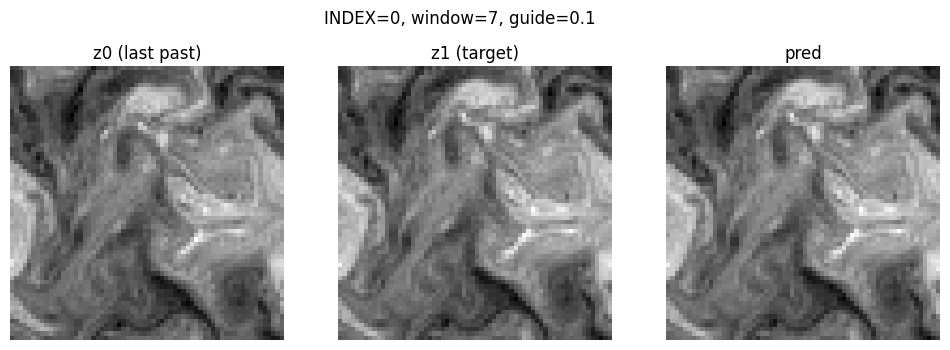

In [19]:
pred = em_sample_conditioned_mc(
    drift=drift, interp=interp,
    xt=z0, cond=cond,
    y_obs=y_obs, operator=operator,
    steps=200, guide=GUIDE, mc_samples=1
)

# quick viz for C=1 or C=2
def show_triplet(z0, z1, pred, title=""):
    z0_ = z0[0].detach().cpu()
    z1_ = z1[0].detach().cpu()
    pr_ = pred[0].detach().cpu()

    nrow = 3
    fig, axes = plt.subplots(1, nrow, figsize=(12,4))
    def im(ax, img, ttl):
        img = img.squeeze(0) if img.dim()==3 and img.shape[0]==1 else img
        if img.dim()==3 and img.shape[0] in [1,3]:
            ax.imshow(img.permute(1,2,0), cmap=None if img.shape[0]==3 else "gray")
        else:
            ax.imshow(img[0], cmap="gray")
        ax.set_title(ttl); ax.axis("off")

    im(axes[0], z0_, "z0 (last past)")
    im(axes[1], z1_, "z1 (target)")
    im(axes[2], pr_, "pred")
    fig.suptitle(title); plt.show()

show_triplet(z0, z1, pred, title=f"INDEX={INDEX}, window={WINDOW}, guide={GUIDE}")

# Sequential assimilation

In [22]:
def _roll_cond(cond: torch.Tensor, new_frame: torch.Tensor, C: int) -> torch.Tensor:
    """
    cond: (B,(T-1)C,H,W)
    new_frame: (B,C,H,W)
    returns updated cond with oldest C channels dropped and new_frame appended.
    """
    B, CC, H, W = cond.shape
    assert CC % C == 0, "cond channels must be multiple of C"
    return torch.cat([cond[:, C:], new_frame], dim=1)


def em_sample_conditioned_dps(
    drift, interp,
    xt,            # (B,C,H,W) current state, will be *updated* and returned
    cond,          # (B,(T-1)C,H,W) conditioner
    y_obs,         # (B,C,H,W) observation at this step (normalized same as training)
    operator,      # differentiable measurement operator, e.g., lambda x: x * mask
    *,
    steps=200, t_min=0.0, t_max=0.999,
    guide=0.1, noise_scale=1.0,
    second_order=True,
    grad_norm=True, # Apply scaling in original DPS paper
):
    """
    One assimilation window: runs an EM-like sampler from t_min..t_max conditioned on y_obs.
    Returns the final xt (detached).
    """
    device = xt.device
    ts = torch.linspace(t_min, t_max, steps, device=device)
    dt = float(ts[1] - ts[0])

    # Freeze model params during sampling
    req = [p.requires_grad for p in drift.parameters()]
    for p in drift.parameters():
        p.requires_grad_(False)

    for t in ts:
        xt = xt.detach().requires_grad_(True)
        tb = t.repeat(xt.shape[0]).to(device)

        # Drift and sigma (no grads through model params)
        with torch.no_grad():
            bF  = drift(xt, tb, cond=cond)       # (B,C,H,W)
            sig = _sigma_broadcast(interp, tb, like=xt)

        # denom = interp.beta(tb) * interp.alpha_dot(tb) - interp.alpha(tb) * interp.beta_dot(tb)
        # x1_hat = (interp.beta(tb) * drift(xt, tb, cond=cond) - interp.beta_dot(tb) * xt) / denom
        denom = interp.sigma(tb) * interp.beta_dot(tb) - interp.beta(tb) * interp.sigma_dot(tb)
        x1_hat = (interp.sigma(tb) * drift(xt, tb, cond=cond) - interp.sigma_dot(tb) * xt) / denom

        meas = operator(x1_hat)
        if grad_norm:
            loss_meas = torch.linalg.vector_norm(meas - y_obs, dim=(1,2,3))
        else:
            loss_meas = (meas - y_obs).pow(2).mean()
        grad_xt = torch.autograd.grad(loss_meas, xt, retain_graph=False, create_graph=False)[0]

        # EM update
        mu  = xt + bF * dt
        eps = torch.randn(mu.shape, device=device)
        xt  = mu + noise_scale * sig * eps * math.sqrt(dt) - guide * grad_xt

        if torch.isnan(xt).sum() > 0:
            print("Got NaNs")
            break

    # restore requires_grad flags
    for p, r in zip(drift.parameters(), req):
        p.requires_grad_(r)

    return xt.detach()
    

def sequential_assimilate(
    drift, interp,
    z0: torch.Tensor,         # (B,C,H,W) initial state (e.g., last frame of history)
    cond: torch.Tensor,       # (B,(T-1)C,H,W) time-flattened past
    y_seq: torch.Tensor,      # (B,N,C,H,W) observations for times 1..N (normalized)
    operator,                 # callable on (B,C,H,W) -> (B,C,H,W) (e.g., fixed mask)
    *,
    steps_per_obs=200,
    guide=0.1, noise_scale=1.0,
    mc_samples=1, 
    second_order=True,
    roll_window=True,
    grad_norm=True,
    method='mc',
):
    """
    Runs N assimilation windows, one per observation y_seq[:,i], starting from z0.
    Returns tensor of predictions with shape (B, N, C, H, W).
    """
    B, N, C, H, W = y_seq.shape
    xt = z0.clone()
    preds = []

    for i in tqdm(range(N)):
        y_obs_i = y_seq[:, i]  # (B,C,H,W)

        if method == 'mc':
            xt = em_sample_conditioned_mc(
                drift=drift, interp=interp,
                xt=xt, cond=cond, 
                y_obs=y_obs_i, operator=operator,
                steps=steps_per_obs, guide=guide, noise_scale=noise_scale,
                mc_samples=mc_samples, second_order=second_order
            )
        elif method == 'dps':
            xt = em_sample_conditioned_dps(
                drift=drift, interp=interp,
                xt=xt, cond=cond, 
                y_obs=y_obs_i, operator=operator,
                steps=steps_per_obs, guide=guide, noise_scale=noise_scale,
                t_min=interp_cfg.t_min_sampling, t_max=interp_cfg.t_max_sampling,
                second_order=second_order,
                grad_norm=grad_norm
            )
        preds.append(xt.unsqueeze(1))  # (B,1,C,H,W)

        if roll_window:
            cond = _roll_cond(cond, xt, C=C)  # slide window forward

    return torch.cat(preds, dim=1)  # (B,N,C,H,W)


In [23]:
traj_len = 42
x_gt = load_single_trajectory(h5_path, INDEX, traj_len,
                           normalize=NORMALIZE, mean=train_mean, std=train_std
                          ).to(device)  # (1,T,C,H,W)

future = x_gt[:, WINDOW-1:]      # (B, N, C, H, W) with N = T-1  (or however many steps you want)
cond, z0, z1 = build_cond_z0_z1(x_gt[:, :WINDOW])

# Build mask ONCE (same mask for all timesteps and batches)
B, N, C, H, W = future.shape
mask = make_mask_like(future[:,0], ratio=OBS_RATIO, seed=0)   # (B,C,H,W)

# Apply to each time in the sequence
y_seq = future * mask.unsqueeze(1)   # (B,N,C,H,W)

# Operator for assimilation
# operator = lambda x: torch.atan(x) * mask        # x: (B,C,H,W) → masked obs
operator = lambda x: x * mask        # x: (B,C,H,W) → masked obs

In [26]:
pred_seq = sequential_assimilate(
    drift, interp,
    z0=z0, cond=cond,
    y_seq=y_seq, operator=operator,
    steps_per_obs=200,
    guide=0.0, noise_scale=0.2,   # try deterministic first: noise_scale=0.0
    mc_samples=1, second_order=True,
    roll_window=True
)  # (B,N,C,H,W)

100%|██████████| 36/36 [04:09<00:00,  6.92s/it]


In [24]:
anal_seq = sequential_assimilate(
    drift, interp,
    z0=z0, cond=cond,
    y_seq=y_seq, operator=operator,
    steps_per_obs=200,
    guide=1.0, noise_scale=0.2,   # try deterministic first: noise_scale=0.0
    mc_samples=1, 
    second_order=True,
    roll_window=True,
    grad_norm=True,
    method='dps',
)  # (B,N,C,H,W)

100%|██████████| 36/36 [06:11<00:00, 10.33s/it]


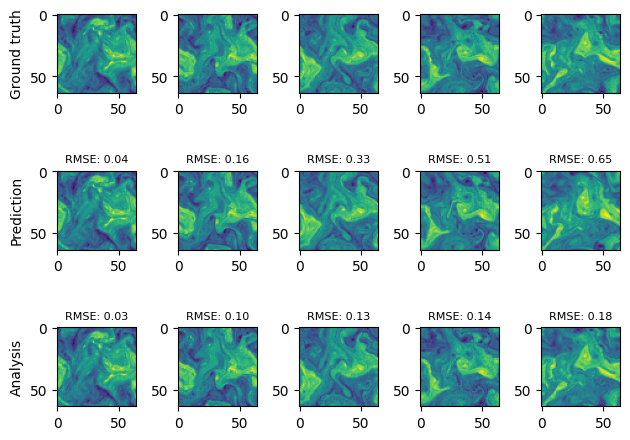

In [27]:
fig, axs = plt.subplots(3, 5)
for i, t in enumerate(range(0, 40, 8)):
    gt = future[0,t]
    axs[0,i].imshow(gt[0].cpu())
    axs[1,i].imshow(pred_seq[0,t,0].cpu(), vmax=gt[0].max(), vmin=gt[0].min())
    axs[1,i].set_title(f"RMSE: {((gt-pred_seq[0,t])**2).mean().sqrt():.2f}", fontsize=8)
    axs[2,i].imshow(anal_seq[0,t,0].cpu(), vmax=gt[0].max(), vmin=gt[0].min())
    axs[2,i].set_title(f"RMSE: {((gt-anal_seq[0,t])**2).mean().sqrt():.2f}", fontsize=8)
    if i == 0:
        axs[0,i].set_ylabel("Ground truth")
        axs[1,i].set_ylabel("Prediction")
        axs[2,i].set_ylabel("Analysis")
plt.tight_layout()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def make_side_by_side_video(gt_seq, pred_seq, out_path="gt_vs_pred.mp4", fps=5):
    """
    Create side-by-side video of ground truth and prediction.
    gt_seq, pred_seq: (B,N,C,H,W) or (N,C,H,W)
    """
    # squeeze batch dimension if present
    if gt_seq.dim() == 5:
        gt_seq = gt_seq[0]
    if pred_seq.dim() == 5:
        pred_seq = pred_seq[0]

    N, C, H, W = gt_seq.shape
    assert pred_seq.shape == (N, C, H, W)

    # pick channel 0 if multi-channel
    gt_seq = gt_seq[:, 0].detach().cpu().numpy()   # (N,H,W)
    pred_seq = pred_seq[:, 0].detach().cpu().numpy()

    # set up figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax_gt, ax_pred = axes
    im_gt = ax_gt.imshow(gt_seq[0], cmap="viridis", origin="lower")
    im_pred = ax_pred.imshow(pred_seq[0], cmap="viridis", origin="lower")
    ax_gt.set_title("Ground Truth")
    ax_pred.set_title("FlowDAS Prediction")
    for ax in axes: ax.axis("off")

    def update(i):
        im_gt.set_data(gt_seq[i])
        im_pred.set_data(pred_seq[i])
        fig.suptitle(f"t = {i}", fontsize=12)
        return im_gt, im_pred

    ani = animation.FuncAnimation(fig, update, frames=N, blit=False, interval=1000/fps)
    ani.save(out_path, writer="ffmpeg", fps=fps)
    plt.close(fig)
    print(f"[video] saved to {out_path}")

# ---------------- example usage ----------------

make_side_by_side_video(x_gt[:, WINDOW-1:].squeeze(), pred_seq.squeeze(), out_path="gt_vs_pred_0.05_atan.gif", fps=2)


In [ ]:
torch.linalg.norm(x_gt[:, WINDOW-1:].squeeze() - pred_seq.squeeze())

In [ ]:
x_gt[:, WINDOW-1:].squeeze().shape

In [ ]:
def compute_rmse(pred, truth):
    rmse = ((pred - truth.unsqueeze(1)) ** 2).mean(dim=(2, 3, 4)).sqrt()
    return rmse

compute_rmse(x_gt[:, WINDOW-1:].squeeze(), pred_seq)

In [ ]:
pred_seq.mean(dim=1).shape

In [ ]:
x_gt[:, WINDOW-1:].squeeze().shape